In [33]:
import numpy as np
import sep

In [34]:
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

In [35]:
# read image into standard 2-d numpy array
with fits.open('f105w.fits') as hdu:
    data = hdu[0].data

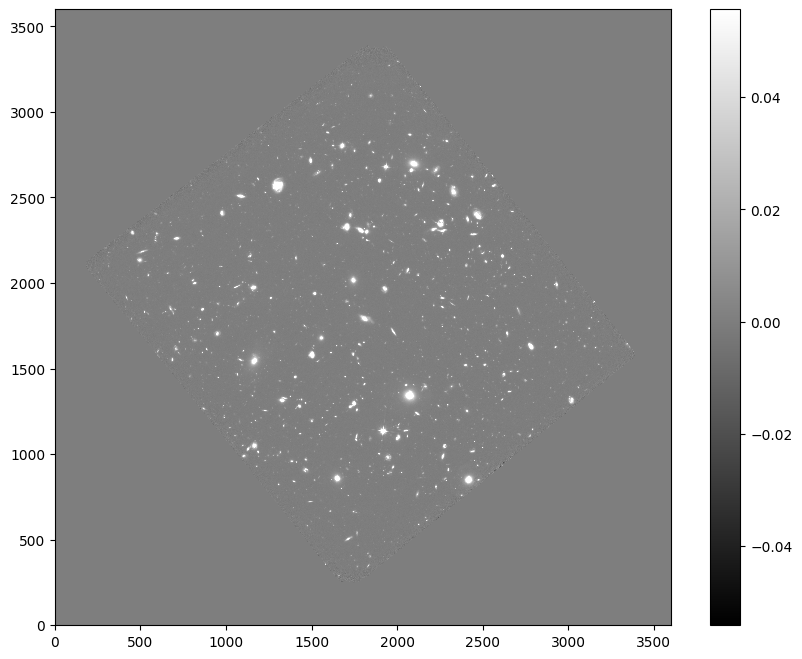

In [36]:
# show the image
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();

plt.savefig('Final-Project-Image1.png', bbox_inches='tight', dpi=600)

# Background Subtraction

In [37]:
# measure a spatially varying background on the image
data = data.byteswap().newbyteorder()
bkg = sep.Background(data)

In [38]:
# get a "global" mean and noise of the image background:
print(bkg.globalback)
print(bkg.globalrms)

0.0
0.0005398219218477607


In [39]:
# evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()
# bkg_image = np.array(bkg) # equivalent to above

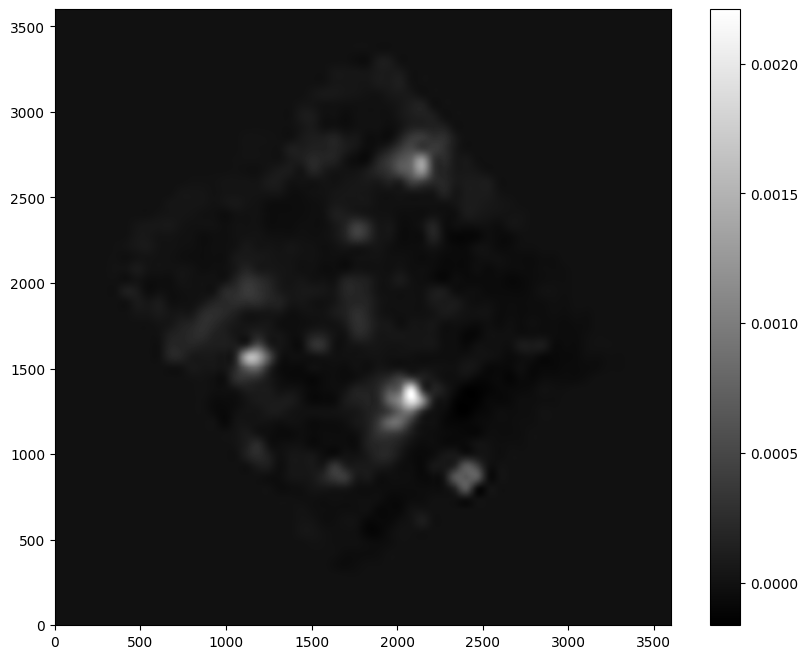

In [40]:
# show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

plt.savefig('Final-Project-Image2.png', bbox_inches='tight', dpi=600)

In [41]:
# evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()

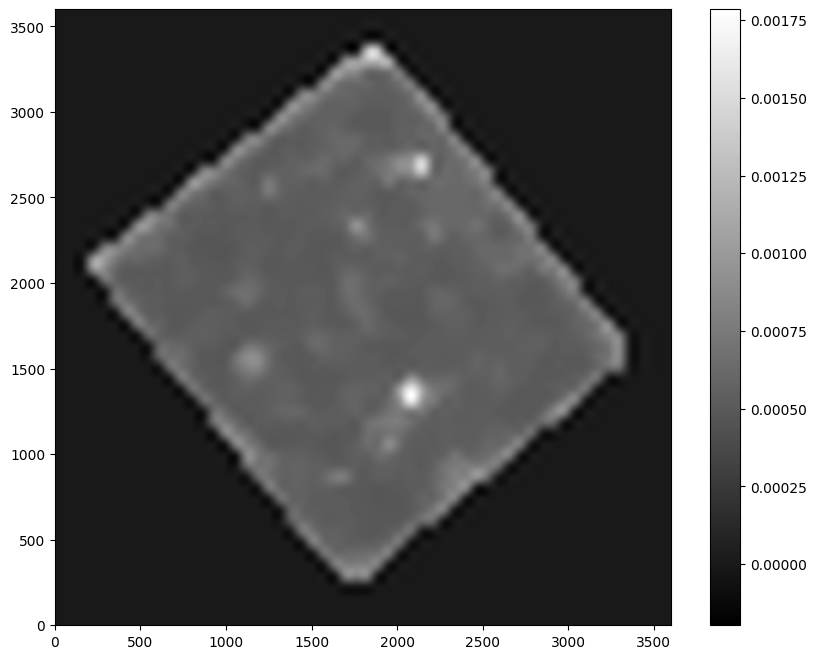

In [42]:
# show the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

plt.savefig('Final-Project-Image3.png', bbox_inches='tight', dpi=600)

In [43]:
# subtract the background
data_sub = data - bkg

# Object Detection

In [44]:
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)

In [45]:
# how many objects were detected
len(objects)

8640

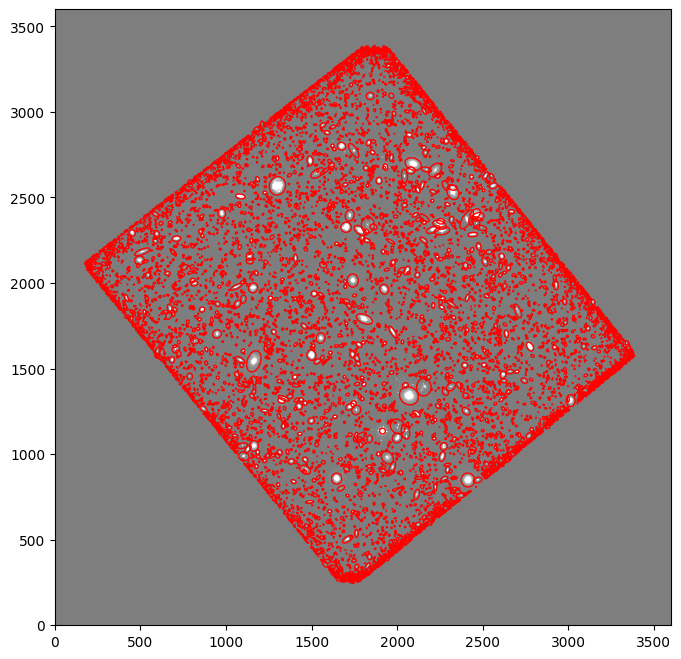

In [46]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

plt.savefig('Final-Project-Image4.png', bbox_inches='tight', dpi=600)

In [47]:
# available fields
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

# Aperture Photometry

In [48]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)

In [49]:
# show the first 10 objects results:
for i in range(8640):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 0.031282 +/- 0.176890
object 1: flux = 0.031018 +/- 0.176142
object 2: flux = -0.024388 +/- 0.002883
object 3: flux = 0.001947 +/- 0.044219
object 4: flux = 0.012457 +/- 0.111649
object 5: flux = -0.011228 +/- 0.002875
object 6: flux = 0.029368 +/- 0.171394
object 7: flux = -0.009126 +/- 0.002875
object 8: flux = 0.048023 +/- 0.219161
object 9: flux = 0.027840 +/- 0.166877
object 10: flux = 0.104682 +/- 0.323559
object 11: flux = 0.044953 +/- 0.212041
object 12: flux = 0.014043 +/- 0.118538
object 13: flux = 0.010265 +/- 0.101357
object 14: flux = 0.011400 +/- 0.106811
object 15: flux = 0.025562 +/- 0.159908
object 16: flux = 0.016498 +/- 0.128478
object 17: flux = -0.008420 +/- 0.002875
object 18: flux = 0.006981 +/- 0.083599
object 19: flux = 0.014791 +/- 0.121653
object 20: flux = -0.002137 +/- 0.002863
object 21: flux = 0.057425 +/- 0.239652
object 22: flux = -0.006278 +/- 0.002863
object 23: flux = 0.034407 +/- 0.185514
object 24: flux = 0.031591 +/- 0.177761
obje

# Histogram Fluxes

There are 8640 sources

/var/folders/2k/k5_kczcj6xv05txbrzf_y0mw0000gn/T/ipykernel_34935/528718893.py:2: RuntimeWarning: invalid value encountered in log
  log_flux = np.log(flux)


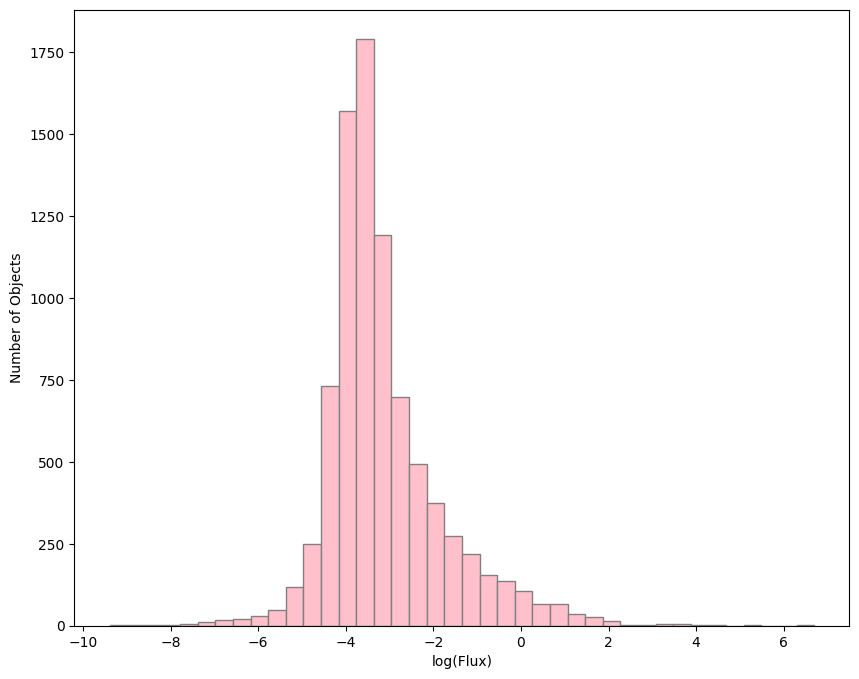

In [50]:
# Logarithmic transformation of flux values
log_flux = np.log(flux)

# Histogram the transformed fluxes
plt.hist(log_flux, bins=40,edgecolor='gray', color='pink')
plt.xlabel('log(Flux)')
plt.ylabel('Number of Objects')
plt.show()

In [51]:
#Statistical Analysis
fluxes_std = np.std(flux)
mean_fluxes = np.mean(flux)
median_fluxes = np.median(flux)

print(f'Standard Deviation of Fluxes: {fluxes_std:.4f}')
print(f'Mean of Fluxes: {mean_fluxes:.4f}')
print(f'Median of Fluxes: {median_fluxes:.4f}')

Standard Deviation of Fluxes: 9.2435
Mean of Fluxes: 0.3619
Median of Fluxes: 0.0310


The largest outlier in the distribution is on the far right of the graph. It log(flux) is around 7. 

In [52]:
var_fluxes = np.var(flux)
print(f'Variance of Fluxes: {var_fluxes:.4f}')

Variance of Fluxes: 85.4428


The variance is how many standard deviations away it is from the mean 

# Read in Images

In [71]:
#define file names
fdata_105 = "f105w.fits"
fdata_160 = "f160w.fits"
fdata_125 = "f125w.fits"

#read in data
hdu_2 = fits.open(fdata_160)
hdu_3 = fits.open(fdata_125)
hdu_4 = fits.open(fdata_105)

#get image data
data_2 = hdu_2[0].data
data_3 = hdu_3[0].data
data_4 = hdu_4[0].data

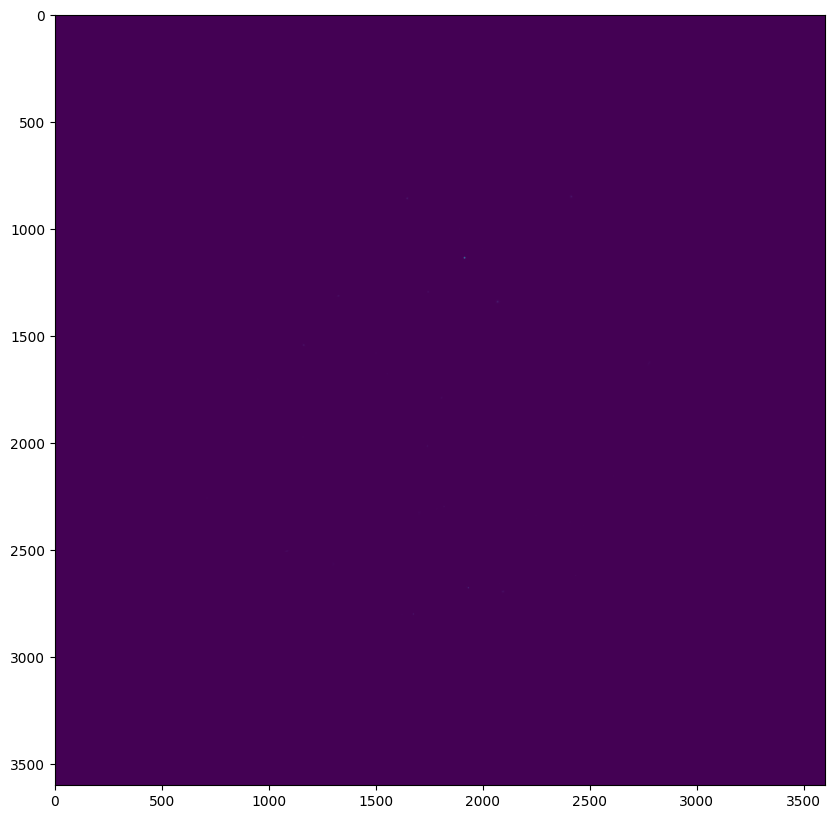

In [72]:
#linear scaling
f = plt.figure(figsize=(10,10))
plt.imshow(data_2)

# Rescale to see faint object

In [73]:
def rescale_image(data):
    pdata_tmp = data.copy()
    m = np.nanmean(pdata_tmp)
    vplmin = m/2.
    vpmin = np.log10(vplmin)
    vpmax = np.log10(m*100.)
    pdata_tmp[pdata_tmp<vplmin] = vplmin
    pdata_tmp = np.log10(pdata_tmp)
    return pdata_tmp,vpmin,vpmax

# Function to plot rescaled data

In [74]:
def fits_quicklook(data,fnx=10,fny=10):
    f = plt.figure(figsize=(fnx,fny))
    pdata_tmp,vpmin,vpmax = rescale_image(data)
    plt.imshow(pdata_tmp,vmin=vpmin,vmax=vpmax)

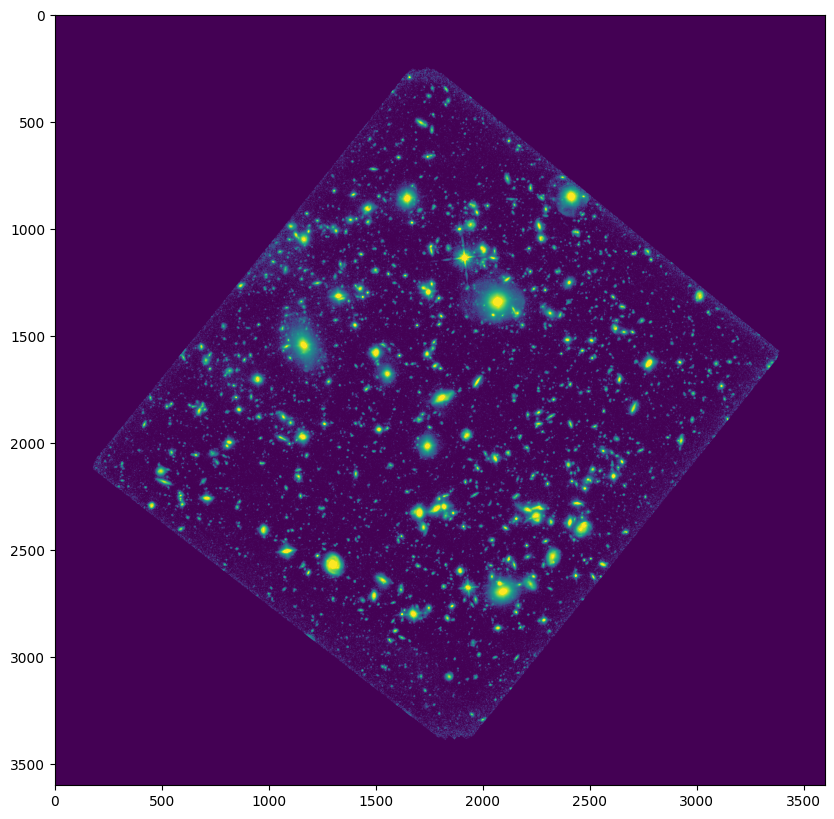

In [75]:
fits_quicklook(data_2)

# Make 3-color false image

In [76]:
data_2_res, d2min, d2max = rescale_image(data_2)
data_3_res, d3min, d3max = rescale_image(data_3)
data_4_res, d4min, d4max = rescale_image(data_4)

# Limit the data to be between the min and max values in the rescaling

In [77]:
data_2_res[data_2_res<d2min] = d2min
data_2_res[data_2_res>d2min] = d2max
data_3_res[data_3_res<d2min] = d3min
data_3_res[data_3_res>d2min] = d3max
data_4_res[data_4_res<d2min] = d4min
data_4_res[data_4_res>d2min] = d4max

In [78]:
rgb = np.zeros((data_2_res.shape[0], data_2_res.shape[1], 3))
rgb[:,:,0] = (data_2_res-d2min)/(d2max-d2min)
rgb[:,:,1] = (data_3_res-d3min)/(d3max-d3min)
rgb[:,:,2] = (data_4_res-d4min)/(d4max-d4min)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


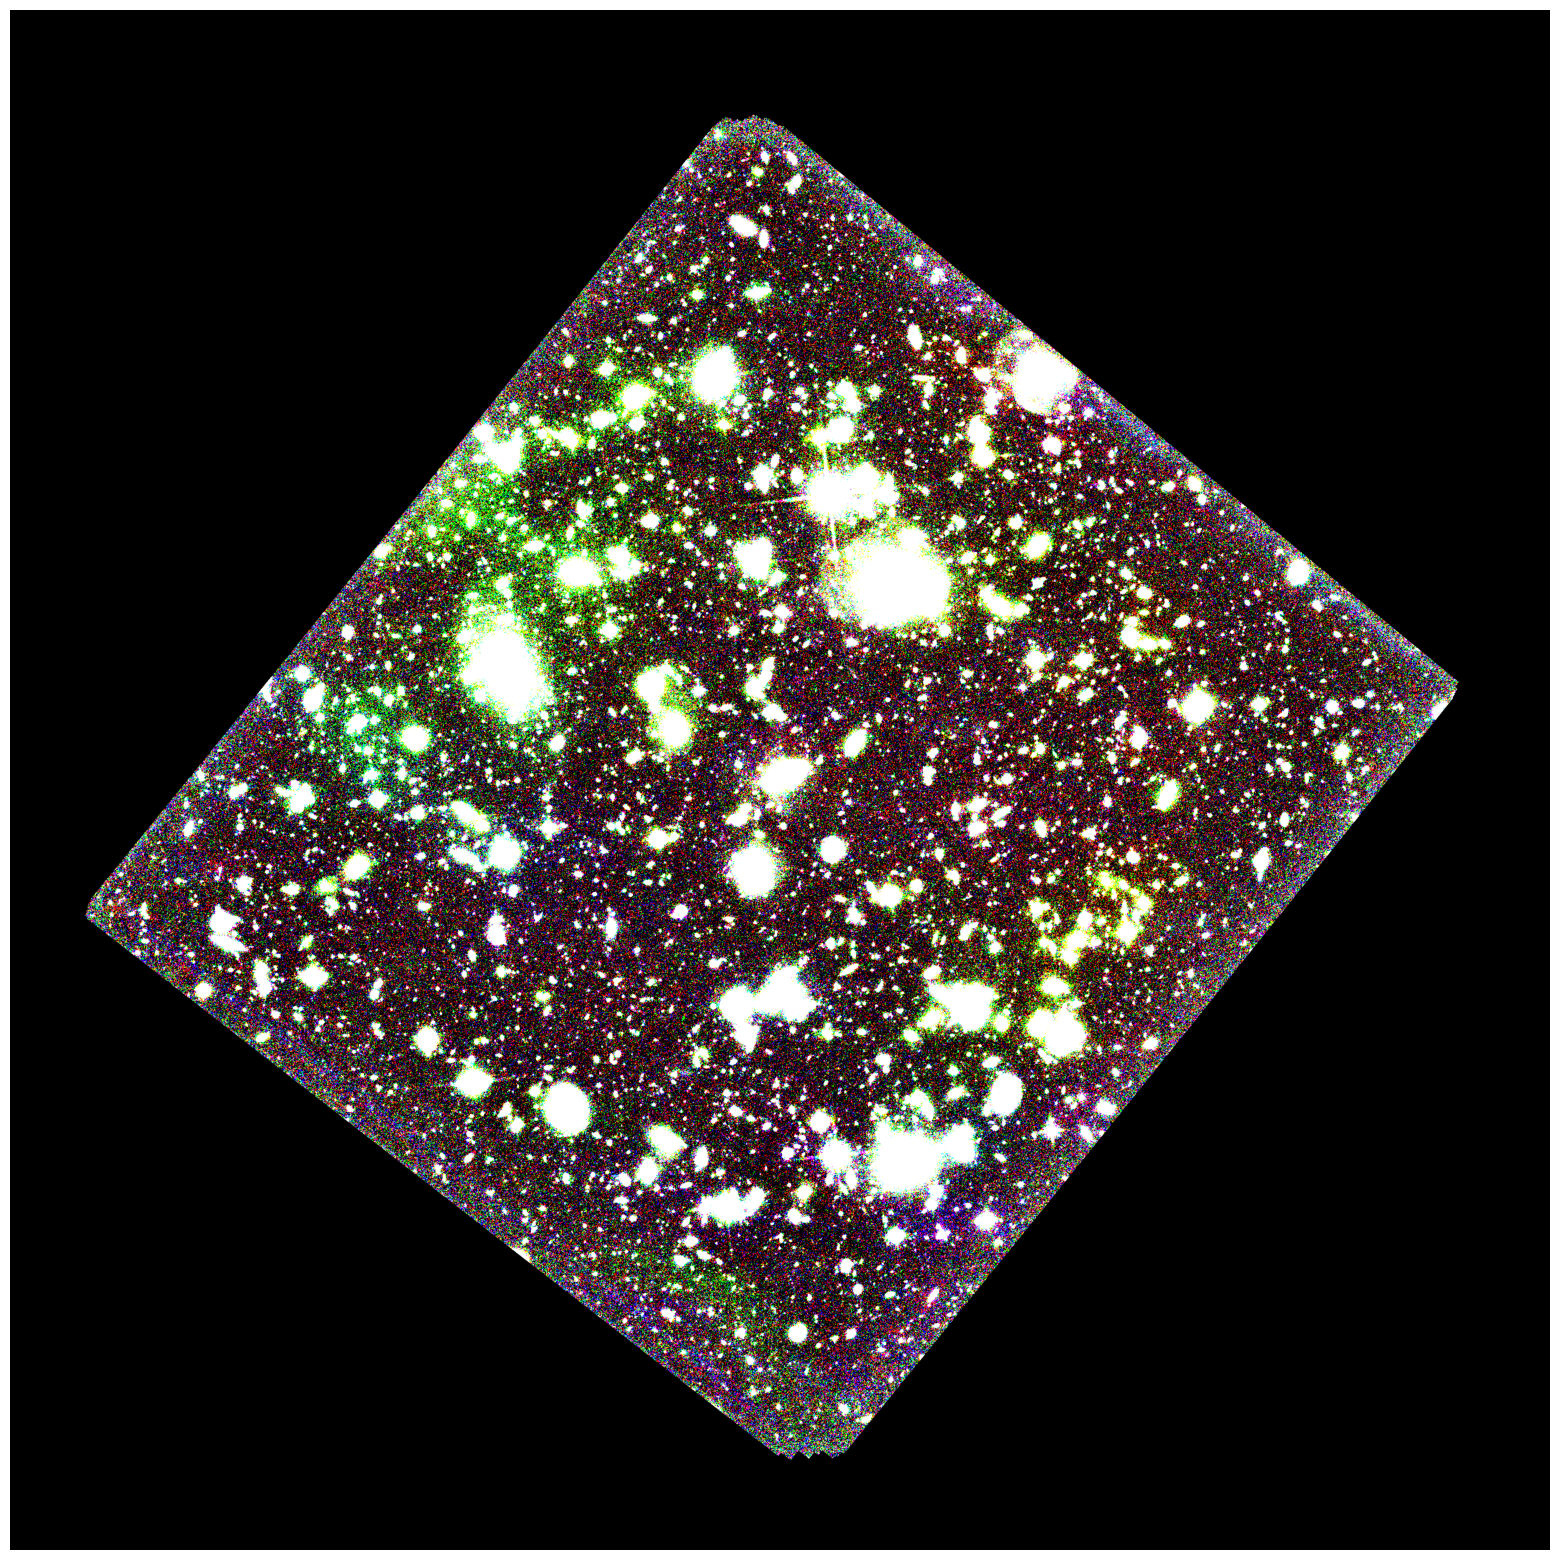

In [90]:
#Plot and save
f, ax = plt.subplots(1,1,figsize=(20,20))
ax.axis('off')
ax.imshow(rgb)
plt.savefig('3-color_false_Image.png',bbox_inches='tight',pad_inches=0,dpi=600)